In [2]:

#read csv files for getting the data
import csv
import os
import sys
import pandas as pd
import numpy as np

#read the csv file
happpy_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\features_10_max_happiness_v2.csv'
happy_df = pd.read_csv(happpy_csv)
happy_df['user'] = happy_df['0'].str.split('_').str[0]  
happy_df['user'] = happy_df['user'].str.split('.').str[0]
happy_df = happy_df.drop(columns=['0'])  
#remove rows with same user
happy_df.set_index('user', inplace=True)
happy_df = happy_df[~happy_df.index.duplicated(keep='first')]
#read the csv file
neutral_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\features_10_true_neutral_v2.csv'
neutral_df = pd.read_csv(neutral_csv)
neutral_df['user'] = neutral_df['0'].str.split('_').str[0]
neutral_df['user'] = neutral_df['user'].str.split('.').str[0]
neutral_df = neutral_df.drop(columns=['0'])
neutral_df.set_index('user', inplace=True)
neutral_df = neutral_df[~neutral_df.index.duplicated(keep='first')]

In [3]:
sialorreha_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\saliva.csv'
map_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\map_id.csv'
saliva_df = pd.read_csv(sialorreha_csv)
saliva_df.set_index('ID', inplace=True)
map_df = pd.read_csv(map_csv)

saliva_df = saliva_df.join(map_df.set_index('Subjet ID'), on='ID')
#remove nan rows where 'ROMP_saliva_Q_done' is nan
saliva_df = saliva_df.dropna(subset=['ROMP_saliva_Q_done','Booth ID'])   
saliva_df = saliva_df[saliva_df['ROMP_saliva_Q_done'] == 'Y']
saliva_df.set_index('Booth ID', inplace=True)
saliva_df.drop(columns=['ROMP_saliva_Q_done','Date','Unnamed: 13'], inplace=True)
saliva_df.index = saliva_df.index.astype(int).astype(str)


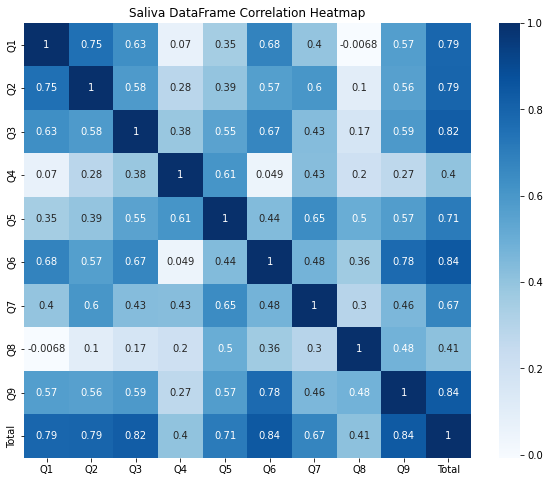

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

#correct column name remove after the first dot
saliva_df.columns = saliva_df.columns.str.split('.').str[0]
# Compute the correlation matrix
correlation_matrix = saliva_df.corr()



# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Saliva DataFrame Correlation Heatmap')
plt.show()


In [5]:
def compute_features(df):
    sqrt_of_sums = np.sqrt(df.iloc[:, -2]**2 + df.iloc[:, -1]**2)

    # Divide all features by this value
    df = df.div(sqrt_of_sums, axis=0)

    # Drop the last two features
    df = df.iloc[:, :-2]
    return df

neutral_df = compute_features(neutral_df)
happy_df = compute_features(happy_df)

happy_df = happy_df.add_suffix('_happy')
neutral_df = neutral_df.add_suffix('_neutral')
#combine the two dataframes
combine_features_df = pd.concat([happy_df, neutral_df], axis=1, join='inner')

# Assuming 'participant_id' in combine_features_df corresponds to 'id' in saliva_df
merged_df = combine_features_df.join(saliva_df, how='inner', rsuffix='_saliva')


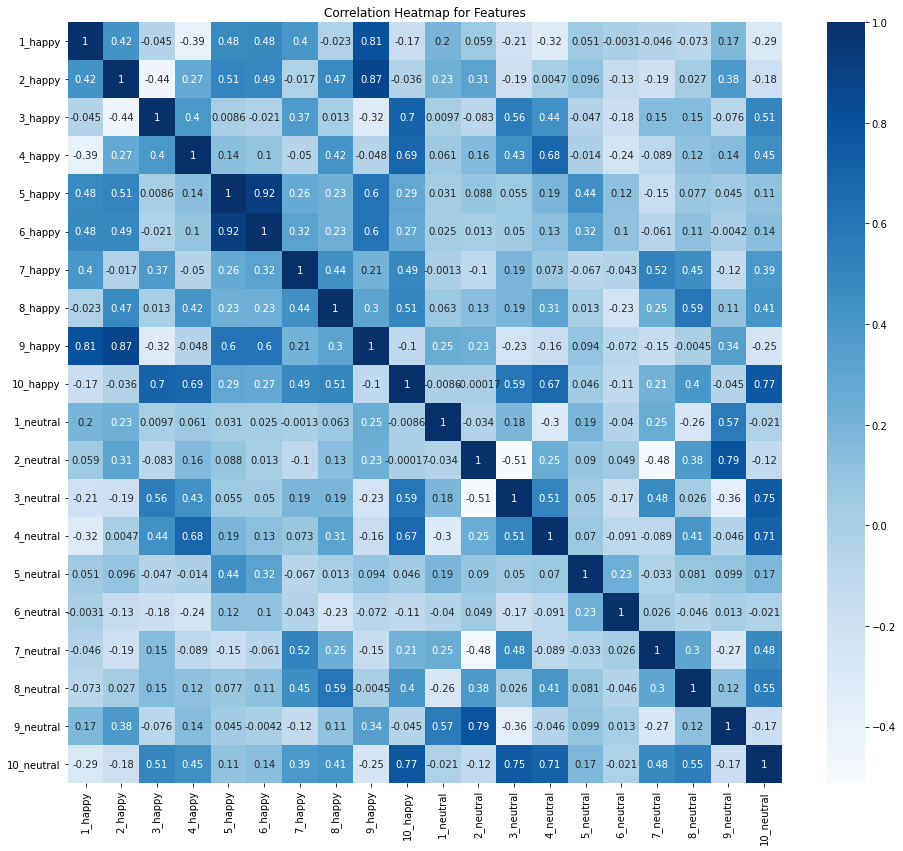

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = combine_features_df.corr()

# Create the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Correlation Heatmap for Features')
plt.show()


In [6]:

import pandas as pd
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the data
Y = scaler.fit_transform(merged_df.iloc[:,-9:])  # Features
X = scaler.fit_transform(merged_df.iloc[:,:-10])  # Questionnaire results

# Initialize CCA with the number of components is the smaller number of columns in the two datasets
n_components = min(saliva_df.shape[1], combine_features_df.shape[1])
n_components=5
cca = CCA(n_components=9)

# Fit CCA
cca.fit(X, Y)

# Transform the data (this step computes the canonical variables)
X_c, Y_c = cca.transform(X, Y)


cca.coef_

array([[ 1.52620962,  1.10171109,  1.15801759,  1.37639262,  0.07703692,
        -0.58241632, -0.34942754, -0.76925876,  1.46942665],
       [ 0.68961028,  1.01929669, -0.02234835,  0.08340456, -0.38090662,
        -0.46267753, -0.35493848, -0.91758838,  0.52415617],
       [-0.74265024, -0.37948256, -0.64139851, -0.67961591,  0.02630147,
         0.16659599,  0.16545203,  0.1798135 , -0.57853054],
       [-0.13786578, -0.30579964,  0.42624205,  0.51862361,  0.40364535,
        -0.07131412,  0.53890479,  0.23822445,  0.36501708],
       [-0.17007244, -0.19040028,  0.37128253,  0.21155871, -0.41183241,
        -0.20211149,  0.41551256,  0.21466668,  0.02212818],
       [ 0.33674371,  0.1959249 , -0.26460679,  0.0883371 ,  0.4414218 ,
         0.24815961, -0.27214665, -0.15822128,  0.24541102],
       [-0.13295755, -0.1351808 , -0.20652327, -0.31077303,  0.08302779,
         0.17533709,  0.17382891,  0.13731552, -0.06092833],
       [-0.13251164, -0.48911109, -0.21021411, -0.2650485 , -0

In [128]:
import pandas as pd
from scipy.stats import pearsonr


# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Feature', 'Saliva_Column', 'Correlation', 'P-Value'])

# Iterate over each feature in combine_features_df
for feature in combine_features_df.columns:
    # Iterate over each column in saliva_df
    for column in saliva_df.columns:
        # Calculate the Pearson correlation coefficient and the p-value
        correlation, p_value = pearsonr(merged_df[feature], merged_df[column])
        
        # Append the results to the results_df
        results_df = results_df.append({'Feature': feature, 'Saliva_Column': column, 'Correlation': correlation, 'P-Value': p_value}, ignore_index=True)

# Optionally, you can filter the results to only keep significant correlations
significant_results_df = results_df[results_df['P-Value'] < 0.05]

print(significant_results_df)


       Feature Saliva_Column  Correlation   P-Value
10     2_happy            Q1    -0.335568  0.048757
72     8_happy            Q3    -0.399992  0.017275
101  1_neutral            Q2    -0.353099  0.037466
115  2_neutral            Q6    -0.425750  0.010774
117  2_neutral            Q8    -0.358165  0.034632
123  3_neutral            Q4    -0.378708  0.024871
137  4_neutral            Q8    -0.501162  0.002164
165  7_neutral            Q6     0.432273  0.009506
167  7_neutral            Q8     0.368325  0.029474
177  8_neutral            Q8    -0.360733  0.033264


In [129]:
#save significant results to a csv file
significant_results_df.to_csv('significant_results_10feaure.csv', index=False)

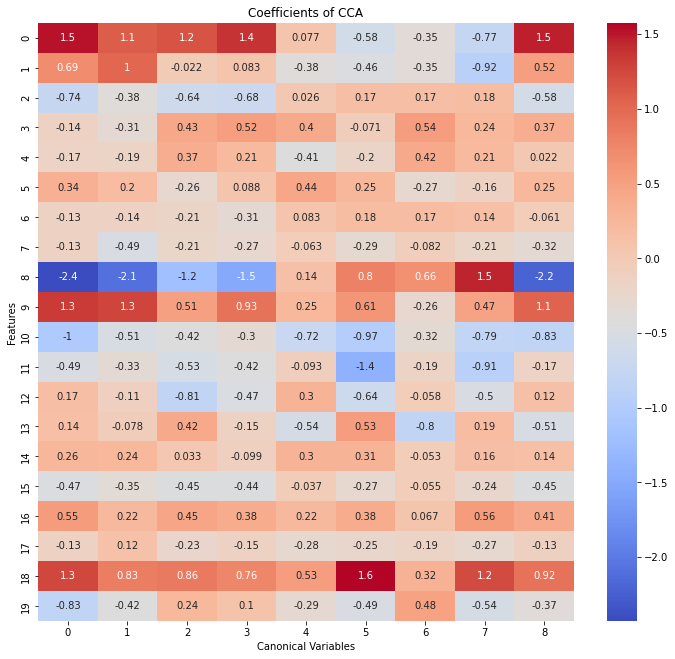

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cca is your CCA object
plt.figure(figsize=(12, 11))
coefficients = cca.coef_

# Create a heatmap
sns.heatmap(coefficients, cmap='coolwarm', annot=True)

# Add labels and title
plt.xlabel('Canonical Variables')
plt.ylabel('Features')
plt.title('Coefficients of CCA')

# Show the plot
plt.show()


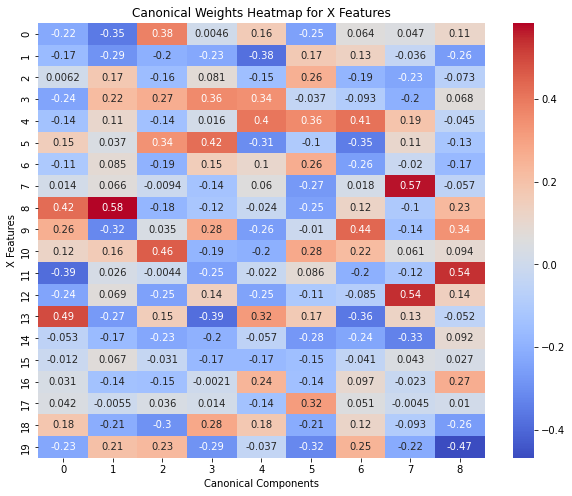

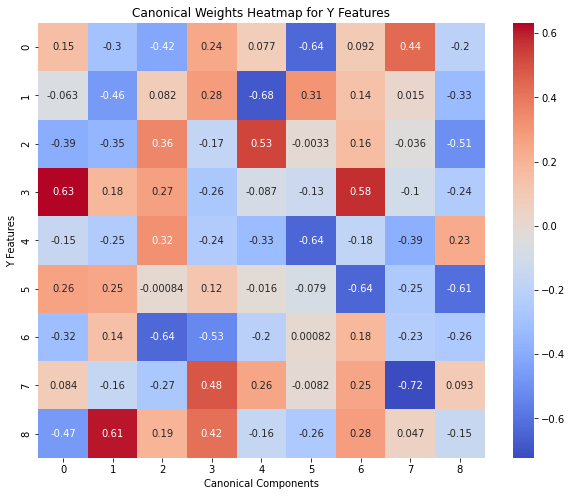

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

weights_X = cca.x_weights_  # Canonical weights for features in X
weights_Y = cca.y_weights_  # Canonical weights for features in Y

# Creating a heatmap for X weights
plt.figure(figsize=(10, 8))
sns.heatmap(weights_X, annot=True, cmap="coolwarm")
plt.title('Canonical Weights Heatmap for X Features')
plt.xlabel('Canonical Components')
plt.ylabel('X Features')
plt.show()

# Repeat similarly for Y weights
plt.figure(figsize=(10, 8))
sns.heatmap(weights_Y, annot=True, cmap="coolwarm")
plt.title('Canonical Weights Heatmap for Y Features')
plt.xlabel('Canonical Components')
plt.ylabel('Y Features')
plt.show()



# Applying CCA with Cross Validation
The results below clearly demonstrate that there is variation in the coefficients, pointing to a possible issue with either the number of data points, the number of features, or even the number of components.



Canonical Correlations for fold: [ 0.58659729 -0.20631577  0.12772264 -0.92087284  0.05764904 -0.3015311
 -0.2750142  -0.72065795 -0.12259148]
Canonical Correlations for fold: [ 0.64884452 -0.29625982 -0.01818491 -0.37058938 -0.31282234  0.25912096
 -0.09742232  0.24939221 -0.09354545]
Canonical Correlations for fold: [ 0.10153216  0.41197719 -0.37718952 -0.65152977 -0.40646858 -0.1641322
 -0.08442522 -0.34181573  0.01858323]
Canonical Correlations for fold: [-0.12980476  0.90702464  0.26874378 -0.12798705 -0.25695555 -0.84854479
 -0.1009686  -0.00112162  0.32224994]
Canonical Correlations for fold: [ 0.15926738  0.74304737 -0.70397438  0.67839895  0.2953525  -0.77463258
  0.02583175  0.55083931 -0.02929553]
Average correlations across folds: [ 0.27328732  0.31189472 -0.14057648 -0.27851602 -0.12464899 -0.36594394
 -0.10639972 -0.05267276  0.01908014]
Standard deviation of correlations across folds: [0.29805703 0.48754134 0.35437554 0.54746402 0.2615226  0.40878187
 0.09644581 0.444507

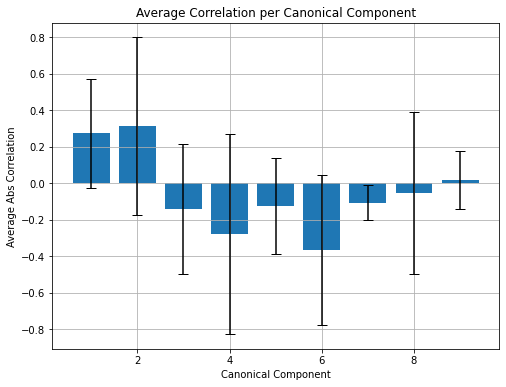

In [15]:
import pandas as pd
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np

# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the data
Y = scaler.fit_transform(merged_df.iloc[:, -9:])  # Features
X = scaler.fit_transform(merged_df.iloc[:, :-10])  # Questionnaire results

#Apply feature selection
pca = PCA(n_components=0.95)

X = pca.fit_transform(X)


# Define the number of components for CCA
n_components = min(Y.shape[1], X.shape[1])

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=22)

# To store correlations for each fold
correlations = []

# Cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Initialize and fit CCA within the fold
    cca = CCA(n_components=n_components)
    cca.fit(X_train, Y_train)
    
    # Transform the data (this step computes the canonical variables)
    X_c, Y_c = cca.transform(X_test, Y_test)
    
    # Calculate and store the correlation for the current fold
    corr = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_components)
    print(f"Canonical Correlations for fold: {corr}")
    correlations.append(corr)

# Aggregate results
average_correlations = np.mean(correlations, axis=0)
print(f"Average correlations across folds: {average_correlations}")

# Optionally, also calculate the standard deviation to estimate variability
std_correlations = np.std(correlations, axis=0)
print(f"Standard deviation of correlations across folds: {std_correlations}")

# Plot the average correlations
plt.figure(figsize=(8, 6))
# plot bar plot with error bars
plt.bar(range(1, n_components+1), average_correlations, yerr=std_correlations, capsize=5)
plt.xlabel('Canonical Component')
plt.ylabel('Average Abs Correlation')
plt.title('Average Correlation per Canonical Component')
plt.grid(True)

# Using Bootstrap and compare loadings


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Average correlations across bootstrap samples: [0.97289466 0.92062666 0.82427819 0.70330293 0.56044525]
Standard deviation of correlations across bootstrap samples: [0.02117262 0.04883146 0.07306413 0.08930722 0.0962381 ]


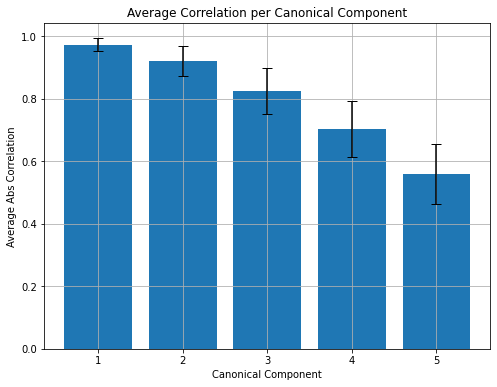

In [16]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample


n_bootstraps = 1000
confidence_level = 0.95
n_components = 5

# Store bootstrapped loadings
bootstrapped_loadings_x = np.zeros((n_bootstraps, X.shape[1], n_components))
bootstrapped_loadings_y = np.zeros((n_bootstraps, Y.shape[1], n_components))

correlations = []
for i in range(n_bootstraps):
    # Resample X and Y with replacement
    X_resampled, Y_resampled = resample(X, Y)
    
    # Fit CCA to the resampled data
    cca = CCA(n_components=n_components)
    cca.fit(X_resampled, Y_resampled)
    
    # Store the loadings
    bootstrapped_loadings_x[i] = cca.x_loadings_
    bootstrapped_loadings_y[i] = cca.y_loadings_
    
    # Transform the data (this step computes the canonical variables)
    X_c, Y_c = cca.transform(X_resampled, Y_resampled)
    
    # Calculate and store the correlation for the current fold
    corr = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_components)
    correlations.append(corr)

# Calculate confidence intervals for loadings
lower_bound_x = np.percentile(bootstrapped_loadings_x, (1 - confidence_level) / 2 * 100, axis=0)
upper_bound_x = np.percentile(bootstrapped_loadings_x, (1 + confidence_level) / 2 * 100, axis=0)

lower_bound_y = np.percentile(bootstrapped_loadings_y, (1 - confidence_level) / 2 * 100, axis=0)
upper_bound_y = np.percentile(bootstrapped_loadings_y, (1 + confidence_level) / 2 * 100, axis=0)

# Aggregate results
average_correlations = np.mean(correlations, axis=0)
print(f"Average correlations across bootstrap samples: {average_correlations}")

# Optionally, also calculate the standard deviation to estimate variability
std_correlations = np.std(correlations, axis=0)
print(f"Standard deviation of correlations across bootstrap samples: {std_correlations}")

# Plot the average correlations
plt.figure(figsize=(8, 6))
# plot bar plot with error bars
plt.bar(range(1, n_components+1), average_correlations, yerr=std_correlations, capsize=5)
plt.xlabel('Canonical Component')
plt.ylabel('Average Abs Correlation')
plt.title('Average Correlation per Canonical Component')
plt.grid(True)

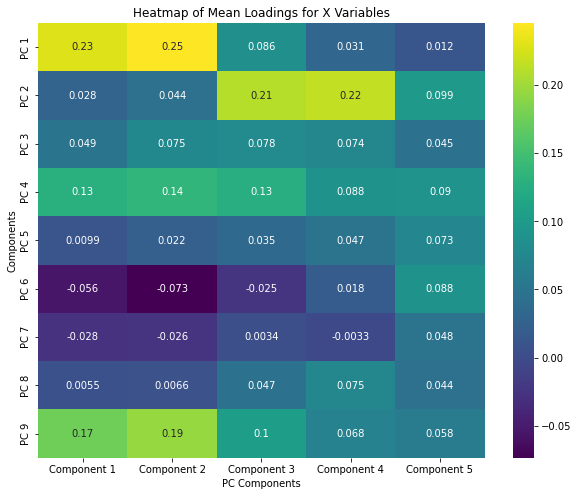

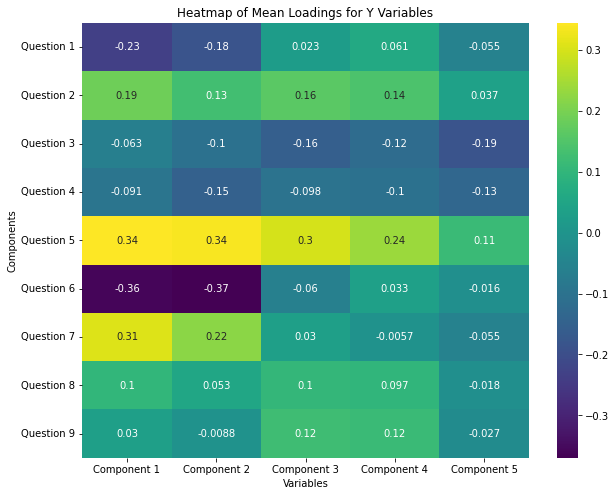

In [17]:
#Plot reasults
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming mean_loadings_x is a numpy array of shape (n_components, n_variables)
mean_loadings_x = np.mean(bootstrapped_loadings_x, axis=0)

# Create a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(mean_loadings_x, annot=True, cmap='viridis',
                 xticklabels=[f'Component {x+1}' for x in range(mean_loadings_x.shape[1])],
                 yticklabels=[f'PC {i+1}' for i in range(mean_loadings_x.shape[0])])

ax.set_title('Heatmap of Mean Loadings for X Variables')
plt.xlabel('PC Components')
plt.ylabel('Components')
plt.show()

#plot the heatmap for Y variables
mean_loadings_y = np.mean(bootstrapped_loadings_y, axis=0)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(mean_loadings_y, annot=True, cmap='viridis',
                 xticklabels=[f'Component {y+1}' for y in range(mean_loadings_y.shape[1])],
                 yticklabels=[f'Question {i+1}' for i in range(mean_loadings_y.shape[0])])

ax.set_title('Heatmap of Mean Loadings for Y Variables')
plt.xlabel('Variables')
plt.ylabel('Components')
plt.show()


In [18]:
# Fit CCA on the entire dataset using the average number of components
cca = CCA(n_components=5)
cca.fit(X, Y)

# Transform the data to get canonical variables
X_c, Y_c = cca.transform(X, Y)


# Scatter plots of commponents

Correlation for pair 1: 0.908758407764574, P-value: 4.507515352576822e-14


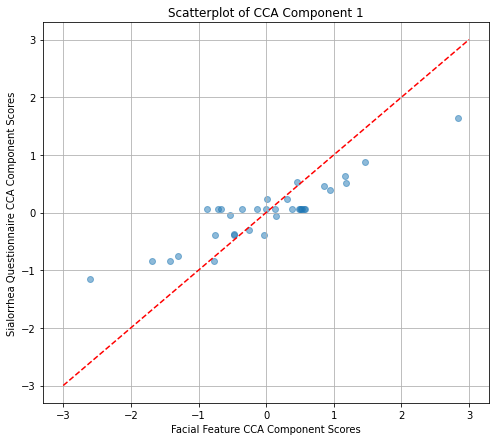

Correlation for pair 2: 0.8345035607733831, P-value: 4.685697202986278e-10


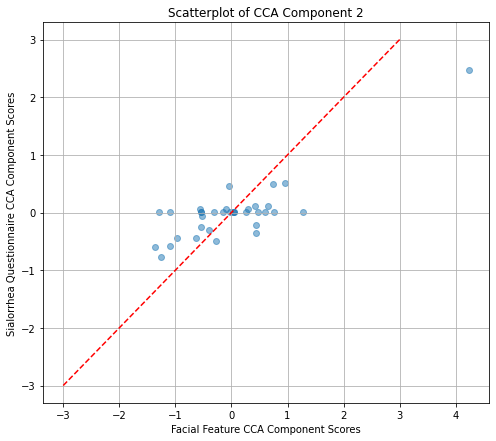

Correlation for pair 3: 0.6396155662506651, P-value: 3.522997712098773e-05


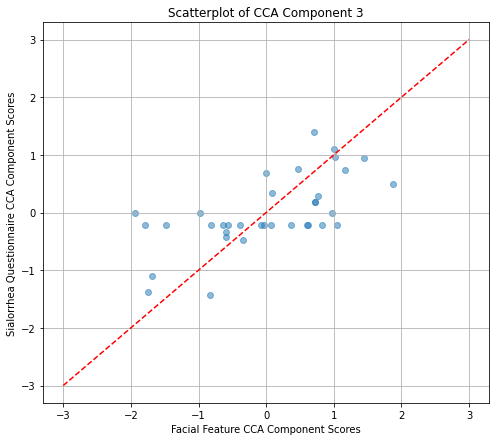

Correlation for pair 4: 0.5035433650555365, P-value: 0.0020448826320592674


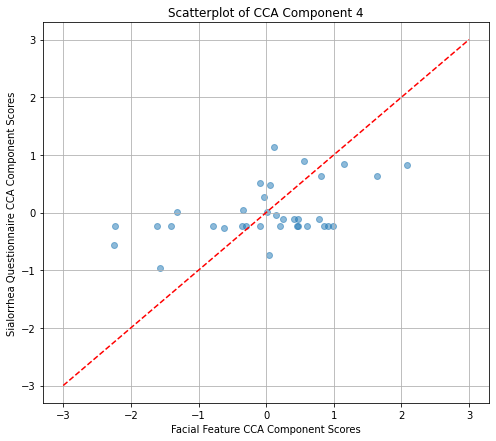

Correlation for pair 5: 0.36408394395250354, P-value: 0.03154471411934946


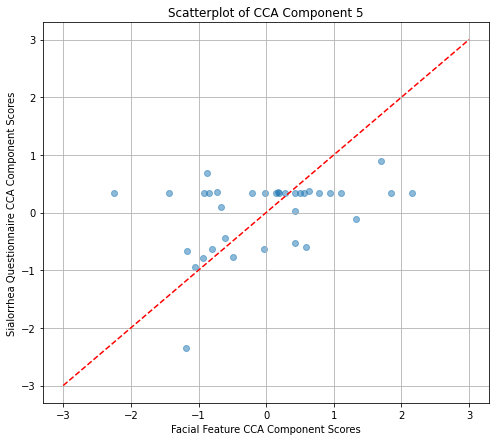

In [19]:
import matplotlib.pyplot as plt

# Number of components to plot
n_components_to_plot = X_c.shape[1]

for i in range(n_components_to_plot):
    corr, p_value = pearsonr(X_c[:, i], Y_c[:, i])
    print(f"Correlation for pair {i+1}: {corr}, P-value: {p_value}")
    plt.figure(figsize=(8,7))
    plt.scatter(X_c[:, i], Y_c[:, i], alpha=0.5)
    #plot x=y line
    plt.plot(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), color='red', linestyle='--')
    plt.title(f'Scatterplot of CCA Component {i+1}')
    plt.xlabel('Facial Feature CCA Component Scores')
    plt.ylabel('Sialorrhea Questionnaire CCA Component Scores')
    plt.grid(True)
    plt.show()


In [20]:
from scipy.stats import pearsonr
import numpy as np

canonical_correlations = cca.score(X, Y)
print("Canonical Correlations:", canonical_correlations)

# Significance testing  using Pearson correlation
for i in range(len(X_c[0])):
    corr, p_value = pearsonr(X_c[:, i], Y_c[:, i])
    print(f"Correlation for pair {i+1}: {corr}, P-value: {p_value}")

Canonical Correlations: -0.5617152290271833
Correlation for pair 1: 0.908758407764574, P-value: 4.507515352576822e-14
Correlation for pair 2: 0.8345035607733831, P-value: 4.685697202986278e-10
Correlation for pair 3: 0.6396155662506651, P-value: 3.522997712098773e-05
Correlation for pair 4: 0.5035433650555365, P-value: 0.0020448826320592674
Correlation for pair 5: 0.36408394395250354, P-value: 0.03154471411934946


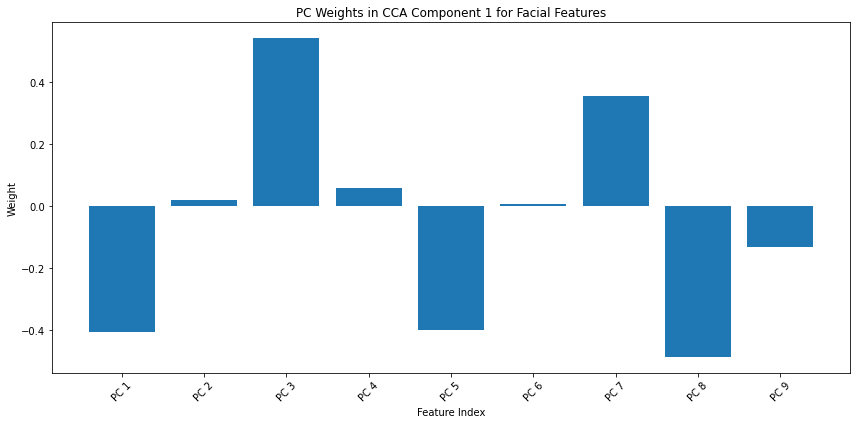

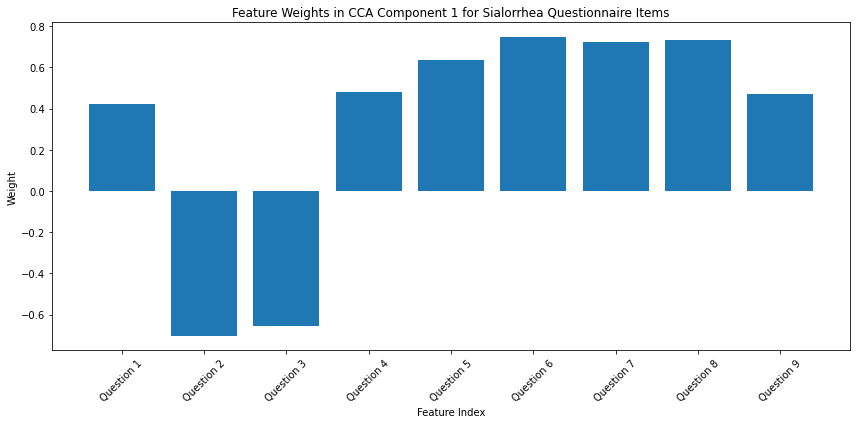

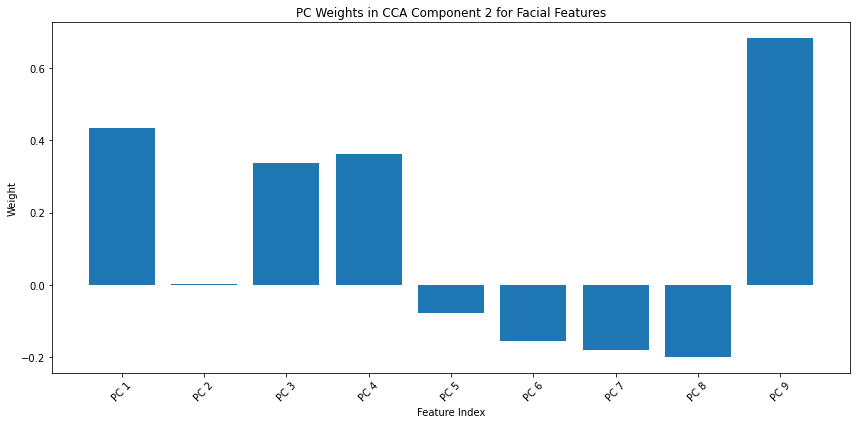

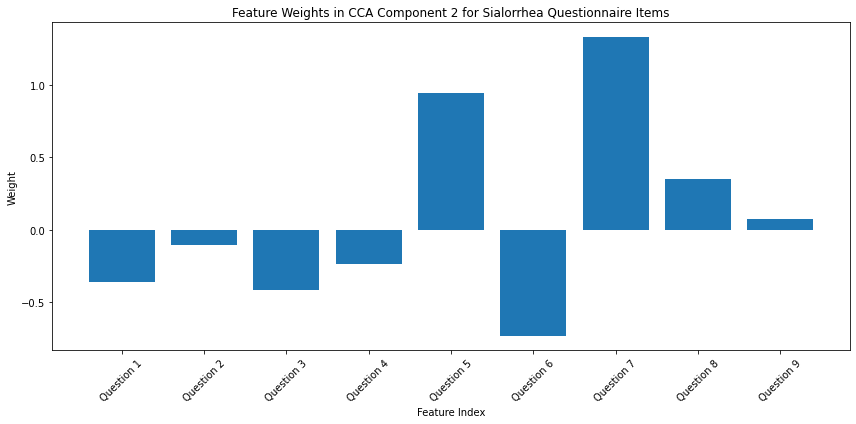

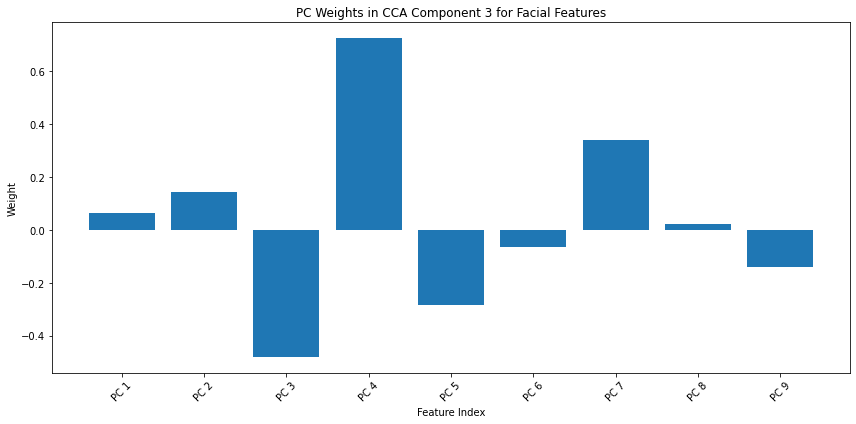

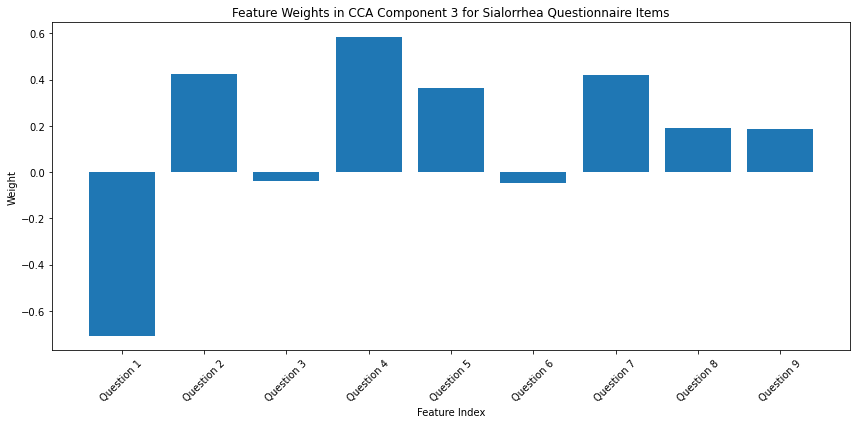

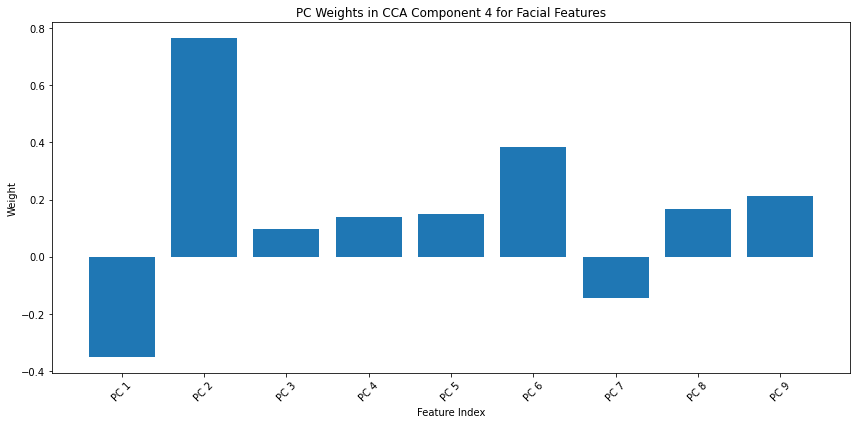

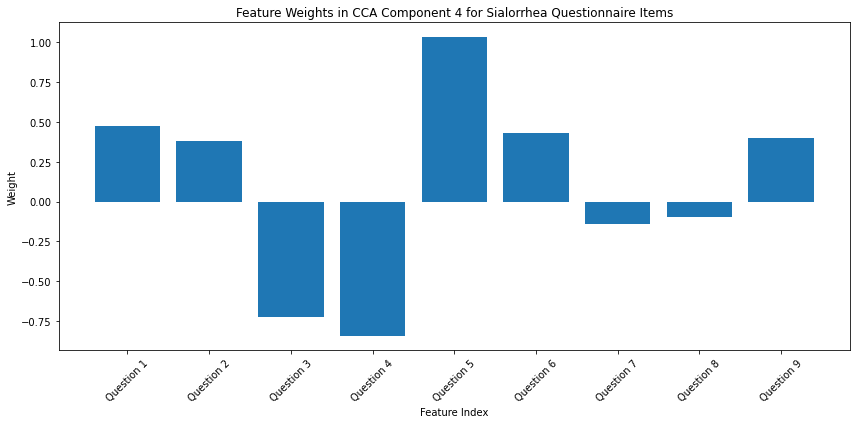

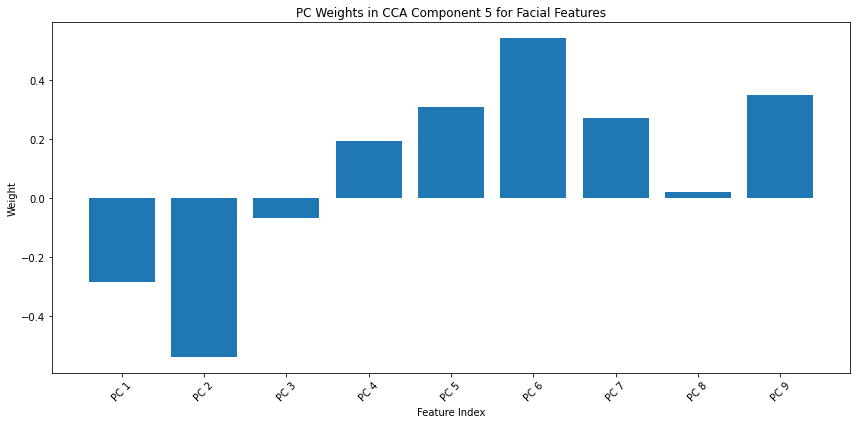

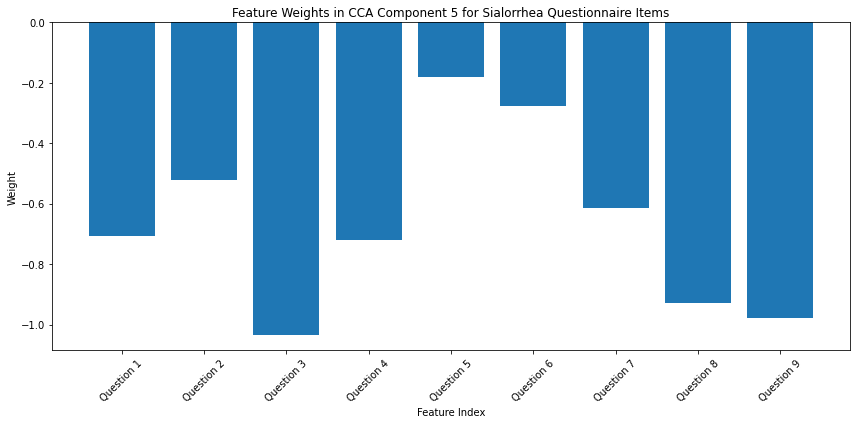

In [26]:
#The left and right singular vectors of the cross-covariance matrices of X and Y
import matplotlib.pyplot as plt


for component_index in range(n_components_to_plot):
    # Extracting weights for the component
    weights_x = cca.x_loadings_[:, component_index]
    weights_y = cca.y_loadings_[:, component_index]

    # Plotting for X features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_x)), weights_x)
    plt.title(f'PC Weights in CCA Component {component_index+1} for Facial Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_x)), [f'PC {i+1}' for i in range(len(weights_x))], rotation=45)
    plt.tight_layout()
    plt.show()

    # Plotting for Y features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_y)), weights_y)
    plt.title(f'Feature Weights in CCA Component {component_index+1} for Sialorrhea Questionnaire Items')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_y)), [f'Question {i+1}' for i in range(len(weights_y))], rotation=45)
    plt.tight_layout()
    plt.show()



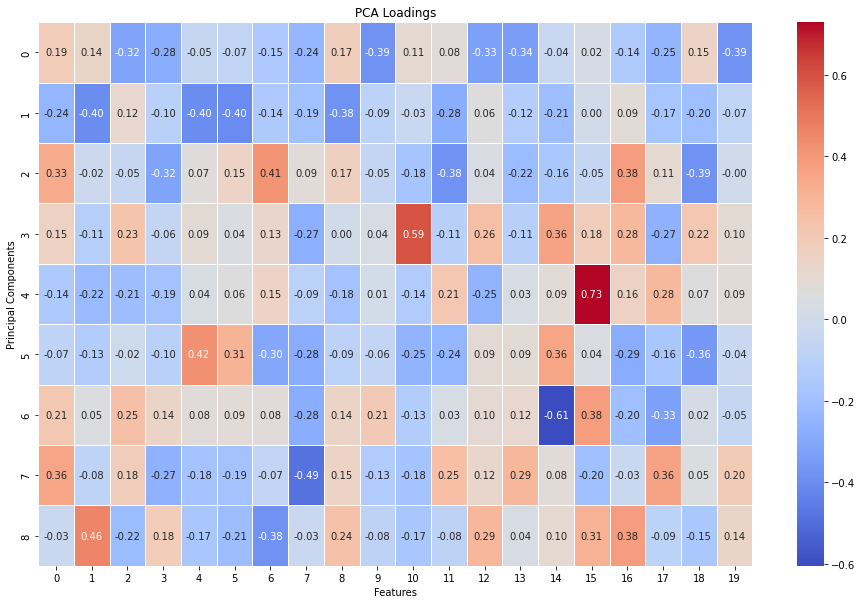

In [24]:
# Magnitude: A higher absolute value of a loading indicates that the variable strongly influences the principal component.
# Sign: The sign (positive or negative) indicates the direction of the influence. Variables with the same sign in a PC are directly related, while those with opposite signs are inversely related.

import seaborn as sns
#Evaluate PCA

import matplotlib.pyplot as plt

# Get the PCA loadings
pca_loadings = pca.components_

# Create a heatmap of the PCA loadings
plt.figure(figsize=(16, 10))
sns.heatmap(pca_loadings, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('PCA Coponents')
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.show()


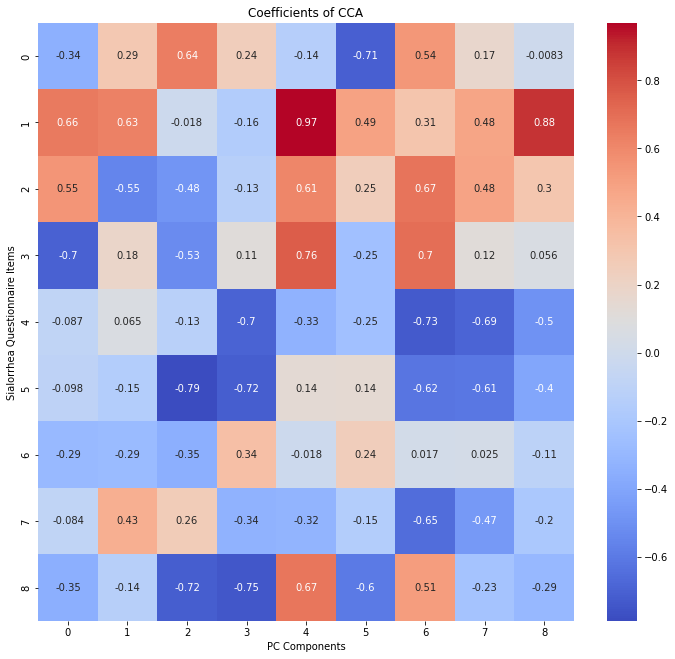

In [28]:
#The coefficients of the linear model such that Y is approximated as Y = X @ coef_.T + b.
# cca coeeficients
plt.figure(figsize=(12, 11))
coefficients = cca.coef_

# Create a heatmap
sns.heatmap(coefficients, cmap='coolwarm', annot=True)

# Add labels and title
plt.xlabel('PC Components')
plt.ylabel('Sialorrhea Questionnaire Items')
plt.title('Coefficients of CCA')

# Show the plot
plt.show()